In [1]:

# Imports
import os, time, random
import numpy as np
import pandas as pd

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Utils
from collections import defaultdict


In [2]:
# Load IEEE-CIS CSVs from Google Drive by FILE ID
import sys, subprocess
from pathlib import Path

# Ensure gdown is available
try:
    import gdown
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])
    import gdown

# File IDs to pull from Google Drive
TXN_ID = "1-D90o63nu_b-N1h-pNUlIRkUMVuP5JLs"
IDM_ID = "1tUZyy06wbS9l-3yTaXC_O8TgbQLjrg6G"

DATA_DIR = Path("./data/ieee-fraud")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Download if missing
txn_path = DATA_DIR / "train_transaction.csv"
idm_path = DATA_DIR / "train_identity.csv"

if not txn_path.exists(): gdown.download(id=TXN_ID, output=str(txn_path), quiet=False)
if not idm_path.exists(): gdown.download(id=IDM_ID, output=str(idm_path), quiet=False)

# Read CSVs (with a forgiving parser fallback)
try:
    txn = pd.read_csv(txn_path, low_memory=False)
except Exception:
    txn = pd.read_csv(txn_path, low_memory=False, engine="python")

try:
    idm = pd.read_csv(idm_path, low_memory=False)
except Exception:
    idm = pd.read_csv(idm_path, low_memory=False, engine="python")

print("train_transaction:", txn.shape)
print("train_identity  :", idm.shape)


/Users/judepereira/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-D90o63nu_b-N1h-pNUlIRkUMVuP5JLs
From (redirected): https://drive.google.com/uc?id=1-D90o63nu_b-N1h-pNUlIRkUMVuP5JLs&confirm=t&uuid=27e24076-a9aa-4fa9-aac6-ef8dec181486
To: /Users/judepereira/Downloads/ieee-fraud-detection/data/ieee-fraud/train_transaction.csv
100%|██████████| 683M/683M [00:21<00:00, 31.4MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1tUZyy06wbS9l-3yTaXC_O8TgbQLjrg6G
To: /Users/judepereira/Downloads/ieee-fraud-detection/data/ieee-fraud/train_identity.csv
100%|██████████| 26.5M/26.5M [00:00<00:00, 31.3MB/s]


train_transaction: (590540, 394)
train_identity  : (144233, 41)


In [3]:
# Derive simple features (day, D1new) and drop TransactionDT
txn["day"] = (txn["TransactionDT"] // (3600 * 24)).astype(int)
txn["D1new"] = (txn["TransactionDT"] // (60*60*24)) - txn["D1"] + 2000
txn.drop("TransactionDT", axis=1, inplace=True)

# Merge identity into transactions, drop TransactionID afterward
df = txn.merge(idm, on="TransactionID", how="left")
df.drop("TransactionID", axis=1, inplace=True)

In [4]:
# seeding
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

SEED = 42
seed_everything(SEED)    

In [5]:

# UID construction helpers
def safe_str(series):
    """Convert to string with an explicit missing token to avoid 'nan' ambiguity."""
    return series.astype("object").where(~series.isna(), "__MISSING__").astype(str)

def compute_uids(df):
    """Stable UID built from card/address/email/C1 with explicit missing token."""
    return (
        safe_str(df['card1']) + "_" +
        safe_str(df['addr1']) + "_" +
        safe_str(df['D1new']) + "_" +
        safe_str(df['P_emaildomain']) + "_" +
        safe_str(df['C1'])
    )


In [6]:
# compute missing % for all columns
nulls = df.isna().mean() * 100

# find columns with more than 80% missing values
cols_80 = nulls[nulls >= 80].index.tolist()

# and drop them!
df.drop(columns=cols_80, inplace=True)

In [7]:
# categorical ID columns
id_cols = [c for c in df.columns if c.startswith("id_")]

# but id_01 to id_11 are numerical so need to exclude them
id_cat_cols = [c for c in id_cols if not c.startswith("id_0")]
id_cat_cols.remove("id_11")  # id_11 is a numerical column

# extract high cardinality categorical ID columns
id_high_card_cols = [c for c in id_cat_cols if df[c].nunique() > 10]

# one-hot encode categorical features with low cardinality
for c in id_cat_cols:
    n_uniq = df[c].nunique()
    print(f"Column: {c}, Unique values: {n_uniq}")
    if n_uniq <= 10:
        print(f"One-hot encoding {c} with {n_uniq} unique values")
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=True)
        df = pd.concat([df.drop(c, axis=1), dummies], axis=1)

Column: id_12, Unique values: 2
One-hot encoding id_12 with 2 unique values
Column: id_13, Unique values: 54
Column: id_15, Unique values: 3
One-hot encoding id_15 with 3 unique values
Column: id_16, Unique values: 2
One-hot encoding id_16 with 2 unique values
Column: id_17, Unique values: 104
Column: id_19, Unique values: 522
Column: id_20, Unique values: 394
Column: id_28, Unique values: 2
One-hot encoding id_28 with 2 unique values
Column: id_29, Unique values: 2
One-hot encoding id_29 with 2 unique values
Column: id_31, Unique values: 130
Column: id_35, Unique values: 2
One-hot encoding id_35 with 2 unique values
Column: id_36, Unique values: 2
One-hot encoding id_36 with 2 unique values
Column: id_37, Unique values: 2
One-hot encoding id_37 with 2 unique values
Column: id_38, Unique values: 2
One-hot encoding id_38 with 2 unique values


In [8]:
# numeric imputation (median) – exclude the target “isFraud”
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("isFraud")

# include id_01 to id_11 as they are numerical
id_num_cols = [c for c in id_cols if c not in id_cat_cols]
num_cols.extend(id_num_cols)

# remove duplicates from the list
num_cols = list(set(num_cols))

# among num_cols, find columns with nans that need to be imputed
nan_cols = [c for c in num_cols if df[c].isna().any()]

# exclude the categorical columns card1, card2, card3, card5, addr1, addr2
cat_cols = ["card1", "card2", "card3", "card5", "addr1", "addr2"]
nan_cols = [c for c in nan_cols if c not in cat_cols]
print(f"Columns with NaNs to be imputed: {nan_cols}")

imputer = SimpleImputer(strategy="median")
df[nan_cols] = imputer.fit_transform(df[nan_cols])

Columns with NaNs to be imputed: ['V288', 'V83', 'V248', 'V178', 'V82', 'V247', 'V93', 'V197', 'D1', 'V262', 'V167', 'id_13', 'V10', 'V84', 'V310', 'V7', 'V103', 'V249', 'V42', 'V35', 'V175', 'V120', 'V208', 'V209', 'V181', 'V259', 'V194', 'id_11', 'V65', 'V271', 'V43', 'V64', 'V74', 'V182', 'V183', 'V136', 'V241', 'V28', 'V213', 'V211', 'V61', 'V105', 'V34', 'V132', 'id_02', 'V280', 'id_19', 'V16', 'V307', 'V283', 'V212', 'V303', 'V76', 'V195', 'V39', 'V308', 'V169', 'V284', 'V260', 'V268', 'V218', 'V214', 'V71', 'V124', 'V179', 'V216', 'D5', 'V227', 'V58', 'V67', 'V272', 'id_06', 'V275', 'V86', 'V302', 'V314', 'V3', 'V231', 'V201', 'V110', 'V117', 'V80', 'V41', 'V54', 'V233', 'V186', 'V2', 'V252', 'V70', 'V53', 'V18', 'V187', 'V60', 'V185', 'V109', 'V11', 'V107', 'V87', 'V69', 'V265', 'V184', 'V235', 'V57', 'V123', 'V135', 'V101', 'V215', 'V122', 'V5', 'V222', 'V44', 'V26', 'V127', 'V108', 'V240', 'V180', 'V300', 'V256', 'V97', 'V133', 'V224', 'V289', 'V189', 'V243', 'V36', 'V88', 'V

In [9]:
# for remaining categoricals, one‐hot encode small‐cardinaliy ones
cat_cols_rem = df.select_dtypes(include=["object"]).columns.tolist()

# include the cat_cols that were excluded earlier
cat_cols_rem.extend(cat_cols)

# remove duplicates from the list
cat_cols_rem = list(set(cat_cols_rem))

# extract high cardinality categorical columns
high_card_cols = [c for c in cat_cols_rem if df[c].nunique() > 10]

# e.g. “ProductCD”, “MISSING” placeholders, etc.
for c in cat_cols_rem:
    n_uniq = df[c].nunique()
    print(f"Column: {c}, Unique values: {n_uniq}")
    if n_uniq <= 10:
        print(f"One-hot encoding {c} with {n_uniq} unique values")
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=True)
        df = pd.concat([df.drop(c, axis=1), dummies], axis=1)

Column: M2, Unique values: 2
One-hot encoding M2 with 2 unique values
Column: card5, Unique values: 119
Column: M3, Unique values: 2
One-hot encoding M3 with 2 unique values
Column: ProductCD, Unique values: 5
One-hot encoding ProductCD with 5 unique values
Column: id_31, Unique values: 130
Column: M4, Unique values: 3
One-hot encoding M4 with 3 unique values
Column: P_emaildomain, Unique values: 59
Column: M1, Unique values: 2
One-hot encoding M1 with 2 unique values
Column: card3, Unique values: 114
Column: card6, Unique values: 4
One-hot encoding card6 with 4 unique values
Column: M9, Unique values: 2
One-hot encoding M9 with 2 unique values
Column: addr2, Unique values: 74
Column: M7, Unique values: 2
One-hot encoding M7 with 2 unique values
Column: M5, Unique values: 2
One-hot encoding M5 with 2 unique values
Column: card2, Unique values: 500
Column: card1, Unique values: 13553
Column: M6, Unique values: 2
One-hot encoding M6 with 2 unique values
Column: DeviceInfo, Unique values:

In [10]:
# include the high cardinality categorical ID columns but remove duplicates
high_card_cols = list(set(high_card_cols + id_high_card_cols))  # remove duplicates
print(f"High cardinality categorical columns: {high_card_cols}")
print(len(high_card_cols))

High cardinality categorical columns: ['card3', 'card5', 'addr2', 'id_17', 'DeviceInfo', 'id_19', 'R_emaildomain', 'id_13', 'card2', 'card1', 'id_31', 'id_20', 'P_emaildomain', 'addr1']
14


In [11]:
# find all bool columns in df
bool_cols = df.select_dtypes(include="bool").columns

# cast them to int (True→1, False→0)
df[bool_cols] = df[bool_cols].astype(int)

In [12]:
df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,...,card6_debit or credit,M9_T,M7_T,M5_T,M6_T,DeviceType_mobile,M8_T,card4_discover,card4_mastercard,card4_visa
0,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,0,0,0,0,1,0,0,1,0,0
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,8.0,gmail.com,...,0,0,0,1,1,0,0,0,1,0
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,outlook.com,...,0,0,0,0,0,0,0,0,0,1
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,8.0,yahoo.com,...,0,0,0,1,0,0,0,0,1,0
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,8.0,gmail.com,...,0,0,0,0,0,1,0,0,1,0


In [13]:
# label encode high cardinality categorical columns and
# Store encoders for later inference
encoders = {}
for col in high_card_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le


In [14]:
# separate all columns from high cardinality categorical columns
other_cols = [c for c in df.columns if c not in high_card_cols]
other_cols.remove("isFraud")

In [15]:
# Faster way to split UIDs into train/val/dev/test sets
# Create UID column using the robust helper
df['UID'] = compute_uids(df)

# Label UIDs as fraud if any txn is fraud, then split
uid_labels = df.groupby('UID')['isFraud'].max().rename('UID_isFraud')
df = df.merge(uid_labels, left_on='UID', right_index=True)

rng = np.random.RandomState(42)
normal_uids = uid_labels[uid_labels == 0].index.values
fraud_uids  = uid_labels[uid_labels == 1].index.values

rng.shuffle(normal_uids)
n_norm = len(normal_uids)
n_train = int(0.60 * n_norm)
n_val   = int(0.20 * n_norm)

train_norm_uids = normal_uids[:n_train]
val_norm_uids   = normal_uids[n_train:n_train+n_val]
hold_norm_uids  = normal_uids[n_train+n_val:]

rng.shuffle(fraud_uids)
n_fraud = len(fraud_uids)
n_fraud_dev = n_fraud // 2
dev_fraud_uids  = fraud_uids[:n_fraud_dev]
test_fraud_uids = fraud_uids[n_fraud_dev:]

n_hold = len(hold_norm_uids)
n_hold_dev = n_hold // 2
dev_norm_uids  = hold_norm_uids[:n_hold_dev]
test_norm_uids = hold_norm_uids[n_hold_dev:]

train_uids = set(train_norm_uids)
val_uids   = set(val_norm_uids)
dev_uids   = set(dev_norm_uids) | set(dev_fraud_uids)
test_uids  = set(test_norm_uids) | set(test_fraud_uids)

def slice_by_uids(df_in, uids):
    return df_in[df_in['UID'].isin(uids)].copy()

train_df = slice_by_uids(df, train_uids)  # normals only
val_df   = slice_by_uids(df, val_uids)    # normals only
dev_df   = slice_by_uids(df, dev_uids)    # mixture
test_df  = slice_by_uids(df, test_uids)   # mixture

print(f"Train(normals) UIDs: {len(train_uids)}  | rows: {train_df.shape[0]}")
print(f"Val(normals)   UIDs: {len(val_uids)}    | rows: {val_df.shape[0]}")
print(f"Dev(mix)       UIDs: {len(dev_uids)}    | rows: {dev_df.shape[0]}")
print(f"Test(mix)      UIDs: {len(test_uids)}   | rows: {test_df.shape[0]}")

# Feature matrices per split (drop label & UID)
X_train = train_df.drop(['isFraud','UID'], axis=1)
X_val   = val_df  .drop(['isFraud','UID'], axis=1)
X_dev   = dev_df  .drop(['isFraud','UID'], axis=1)
X_test  = test_df .drop(['isFraud','UID'], axis=1)


Train(normals) UIDs: 187885  | rows: 340202
Val(normals)   UIDs: 62628    | rows: 113875
Dev(mix)       UIDs: 37395    | rows: 68652
Test(mix)      UIDs: 37397   | rows: 67811


In [16]:
# Identify one-hot columns (all values are 0 or 1)
one_hot_cols = [col for col in X_train.columns if set(X_train[col].unique()) <= {0, 1}]

# Define columns to be standardized
std_cols = [col for col in X_train.columns if col not in one_hot_cols and col not in high_card_cols]


In [17]:
# Standardize features
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled    = X_val.copy()
X_dev_scaled    = X_dev.copy()
X_test_scaled   = X_test.copy()

X_train_scaled[std_cols] = scaler.fit_transform(X_train[std_cols])
X_val_scaled[std_cols]   = scaler.transform(X_val[std_cols])
X_dev_scaled[std_cols]   = scaler.transform(X_dev[std_cols])
X_test_scaled[std_cols]  = scaler.transform(X_test[std_cols])

In [18]:
# Convert to PyTorch tensors
X_num_train = torch.tensor(X_train_scaled[other_cols].values, dtype=torch.float32)
X_cat_train = torch.tensor(X_train_scaled[high_card_cols].values, dtype=torch.long)

X_num_val = torch.tensor(X_val_scaled[other_cols].values, dtype=torch.float32)
X_cat_val = torch.tensor(X_val_scaled[high_card_cols].values, dtype=torch.long)

X_num_dev = torch.tensor(X_dev_scaled[other_cols].values, dtype=torch.float32)
X_cat_dev = torch.tensor(X_dev_scaled[high_card_cols].values, dtype=torch.long)

X_num_test = torch.tensor(X_test_scaled[other_cols].values, dtype=torch.float32)
X_cat_test = torch.tensor(X_test_scaled[high_card_cols].values, dtype=torch.long)


In [19]:
# Create TensorDatasets for train/val/dev/test sets
train_ds = TensorDataset(X_num_train, X_cat_train, X_num_train, X_cat_train)
val_ds   = TensorDataset(X_num_val, X_cat_val, X_num_val, X_cat_val)
dev_ds   = TensorDataset(X_num_dev, X_cat_dev, X_num_dev, X_cat_dev)
test_ds  = TensorDataset(X_num_test, X_cat_test, X_num_test, X_cat_test)

# Build Pytorch loaders
BATCH_SIZE = 512

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
dev_loader   = DataLoader(dev_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [20]:
# model definition with categorical embeddings
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoderWithEmbeddings(nn.Module):
    def __init__(self, num_numeric, cat_cardinalities, hidden1=128, hidden2=64, code_size=8, dropout_rate=0.2):
        super(AutoEncoderWithEmbeddings, self).__init__()
        
        # Create embeddings for each categorical feature
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, min(50, (num_categories + 1)//2))
            for num_categories in cat_cardinalities
        ])
        
        emb_size_total = sum([emb.embedding_dim for emb in self.embeddings])
        total_input_size = num_numeric + emb_size_total
        
        self.dropout = nn.Dropout(dropout_rate)
        
        # Encoder
        self.fc1 = nn.Linear(total_input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, code_size)
        
        # Decoder
        self.fc4 = nn.Linear(code_size, hidden2)
        self.fc5 = nn.Linear(hidden2, hidden1)
        self.fc6 = nn.Linear(hidden1, total_input_size)
    
    def forward(self, x_num, x_cat):
        # Embed categorical variables
        embeds = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        embeds = torch.cat(embeds, dim=1)
        
        # Concatenate numerical + embeddings
        x = torch.cat([x_num, embeds], dim=1)

        # Encoder with dropout noise
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        code = F.relu(self.fc3(x))
        
        # Decoder
        x = F.relu(self.fc4(code))
        x = self.dropout(x)
        
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        
        output = self.fc6(x)  # Linear activation
        return output

In [21]:

def per_sample_mse(model, generator):
    # Targets are built from *detached* embedding lookups to avoid target leakage
    model.eval()
    crit = torch.nn.MSELoss(reduction="none")
    losses = []
    with torch.no_grad():
        for xb_num, xb_cat, yb_num, yb_cat in generator:
            # Forward pass
            y_pred = model(xb_num, xb_cat)

            # Construct full target (numeric + embeddings)
            true_embeds = []
            if xb_cat.shape[1] > 0:
                for i in range(len(model.embeddings)):
                    true_embeds.append(model.embeddings[i](yb_cat[:, i]))
            y_true_full = torch.cat([yb_num] + true_embeds, dim=1) if true_embeds else yb_num

            # Compute Loss
            l = crit(y_pred, y_true_full).mean(dim=1).cpu().numpy()
            losses.extend(l.tolist())
    return np.array(losses)


In [22]:

def evaluate_model(model,generator,criterion):
    # Detached embedding targets for validation loss
    model.eval()
    batch_losses = []
    with torch.no_grad():
        for xb_num, xb_cat, yb_num, yb_cat in generator:
            # Forward pass
            y_pred = model(xb_num, xb_cat)

            # Construct full target (numeric + embeddings)
            true_embeds = []
            if xb_cat.shape[1] > 0:
                for i in range(len(model.embeddings)):
                    true_embeds.append(model.embeddings[i](yb_cat[:, i]))
            y_true_full = torch.cat([yb_num] + true_embeds, dim=1) if true_embeds else yb_num

            # Compute Loss
            loss = criterion(y_pred, y_true_full).mean(dim=1)
            batch_losses.extend(list(loss.cpu().numpy()))
    return float(np.mean(batch_losses))


In [23]:

def training_loop(model,training_generator,valid_generator,optimizer,criterion,
                  max_epochs=100,apply_early_stopping=True,patience=3,verbose=False):
    # Train with detached embedding targets; early stop on Val(normals) and restore best checkpoint
    model.train()

    class EarlyStopping:
        def __init__(self, patience=3, verbose=False):
            self.patience = patience
            self.verbose = verbose
            self.counter = 0
            self.best_score = np.inf
            self.best_state = None
        def step(self, current_score, model):
            if current_score < self.best_score:
                self.best_score = current_score
                self.counter = 0
                self.best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
                if self.verbose:
                    print("New best score:", current_score)
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement. Patience {self.counter}/{self.patience}")
            return self.counter < self.patience

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)

    all_train_losses = []
    all_valid_losses = []
    start_time=time.time()

    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for xb_num, xb_cat, yb_num, yb_cat in training_generator:
            optimizer.zero_grad()
            y_pred = model(xb_num, xb_cat)
            # detach embedding targets
            with torch.no_grad():
                true_embeds = []
                if xb_cat.shape[1] > 0:
                    for i in range(len(model.embeddings)):
                        true_embeds.append(model.embeddings[i](yb_cat[:, i]))
                y_true_full = torch.cat([yb_num] + true_embeds, dim=1) if true_embeds else yb_num
            loss = criterion(y_pred, y_true_full).mean()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        valid_loss = evaluate_model(model,valid_generator,criterion)
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.step(valid_loss, model):
                if verbose:
                    print("Early stopping")
                break

    training_execution_time=time.time()-start_time
    if apply_early_stopping and early_stopping.best_state is not None:
        model.load_state_dict(early_stopping.best_state)

    return model,training_execution_time,all_train_losses,all_valid_losses


In [24]:
# Number of numeric features (including one-hot encodings)
num_numeric = len(other_cols)

# Cardinalities of only high cardinality categorical features
cat_cardinalities = [df[col].nunique() for col in high_card_cols]

# Initialize the embedding autoencoder model
seed_everything(SEED)
model = AutoEncoderWithEmbeddings(num_numeric=num_numeric, 
                            cat_cardinalities=cat_cardinalities,
                            hidden1=128, hidden2=64, code_size=8, dropout_rate=0.2)

# specify loss criterion and optimizer
criterion = torch.nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Generate losses before training
losses = per_sample_mse(model, val_loader)


In [25]:
print(losses[0:5])
print(np.mean(losses))

[0.82158989 0.75248271 0.92592669 0.79902416 2.78271389]
0.992743988196753


In [26]:
# Train with early stopping on Val (normals)
model, train_time, _, _ = training_loop(model, train_loader, val_loader, optimizer, criterion,
                                        max_epochs=100, apply_early_stopping=True, patience=5, verbose=True)


Epoch 0: train loss: 0.6386288922532161
valid loss: 0.5076649785041809
New best score: 0.5076649785041809

Epoch 1: train loss: 0.5157344058043974
valid loss: 0.4896448254585266
New best score: 0.4896448254585266

Epoch 2: train loss: 0.49279377559073884
valid loss: 0.47354671359062195
New best score: 0.47354671359062195

Epoch 3: train loss: 0.47923348344358285
valid loss: 0.46678316593170166
New best score: 0.46678316593170166

Epoch 4: train loss: 0.4692506359483963
valid loss: 0.454958438873291
New best score: 0.454958438873291

Epoch 5: train loss: 0.4567936280616244
valid loss: 0.44270047545433044
New best score: 0.44270047545433044

Epoch 6: train loss: 0.4427864826263342
valid loss: 0.4285190999507904
New best score: 0.4285190999507904

Epoch 7: train loss: 0.43177939931252846
valid loss: 0.4208871126174927
New best score: 0.4208871126174927

Epoch 8: train loss: 0.4240803517345199
valid loss: 0.41436275839805603
New best score: 0.41436275839805603

Epoch 9: train loss: 0.4179

In [27]:
# Define 70% threshold based on dev set
dev_errs = per_sample_mse(model, dev_loader)
thresh = float(np.percentile(dev_errs, 70.0))
print("Dev 70th percentile error threshold =", thresh)

Dev 70th percentile error threshold = 0.3363437473773956


In [28]:
# final test evaluation (UID level) using dev-based threshold
from sklearn.metrics import roc_auc_score
# Compute errors on test set
test_errs = per_sample_mse(model, test_loader)

# Construct dictionary to store UID-level errors
uid_errors = defaultdict(list)
for uid, err in zip(test_df['UID'].values, test_errs):
    uid_errors[uid].append(err)

# Average error per UID for average rule
uid_avg = {u: float(np.mean(es)) for u, es in uid_errors.items()}

# Create data frame to store average error per UID
uid_df  = pd.DataFrame.from_dict(uid_avg, orient='index', 
                                  columns=['avg_error'])

# Define ground-truth label
uid_df['true_label'] = uid_df.index.isin(fraud_uids).astype(int)

# metrics
auc = roc_auc_score(uid_df['true_label'], uid_df['avg_error'])
print(f"UID‐level ROC AUC: {auc:.4f}")

UID‐level ROC AUC: 0.8023


In [29]:
from sklearn.metrics import recall_score, precision_score

uid_df['pred'] = (uid_df['avg_error'] >= thresh).astype(int)
recall   = recall_score(uid_df['true_label'], uid_df['pred'])    # binary‐class recall
precision = precision_score(uid_df['true_label'], uid_df['pred'])  # binary‐class precision
print(f"Recall at 70th percentile dev-error threshold = {recall:.4f}")
print(f"Precision at 70th percentile dev-error threshold = {precision:.4f}")

Recall at 70th percentile dev-error threshold = 0.7182
Precision at 70th percentile dev-error threshold = 0.3461


In [30]:
# UID‐level evaluation via fraction‐rule

# For each UID, compute fraction of its txns flagged as fraud
uid_frac = {u: float((np.array(es) >= thresh).mean()) for u, es in uid_errors.items()}

# Build DataFrame and true labels
uid_df = pd.DataFrame.from_dict(uid_frac, orient='index',
                                columns=['fraud_frac'])
uid_df['true_label'] = uid_df.index.isin(fraud_uids).astype(int)

# Classify UID as fraud if majority of its txns exceed threshold
uid_df['pred'] = (uid_df['fraud_frac'] >= 0.50).astype(int)

# Compute metrics
auc_frac = roc_auc_score(uid_df['true_label'], uid_df['fraud_frac'])
recall_frac = recall_score(uid_df['true_label'], uid_df['pred'])
precision_frac = precision_score(uid_df['true_label'], uid_df['pred'])

print(f"UID‐level ROC AUC (fraction rule):       {auc_frac:.4f}")
print(f"UID‐level recall (majority‐vote rule): {recall_frac:.4f}")
print(f"UID‐level precision (majority‐vote rule): {precision_frac:.4f}")


UID‐level ROC AUC (fraction rule):       0.7370
UID‐level recall (majority‐vote rule): 0.7192
UID‐level precision (majority‐vote rule): 0.3412


In [31]:
# uid_avg: {UID -> avg_error}
# uid_frac: {UID -> fraud_frac}
uid_df = (
    pd.DataFrame.from_dict(uid_avg, orient='index', columns=['avg_error'])
      .join(pd.DataFrame.from_dict(uid_frac, orient='index', columns=['fraud_frac']),
            how='outer')
      .astype({'avg_error': 'float64', 'fraud_frac': 'float64'})
)
uid_df.index.name = 'UID'

# add true labels
uid_df['true_label'] = uid_df.index.isin(fraud_uids).astype(int)


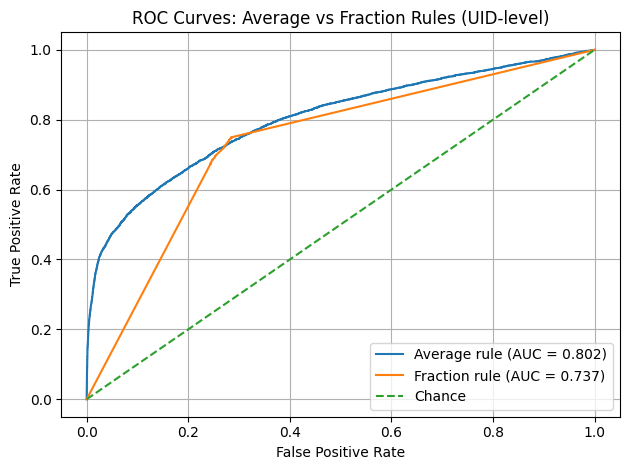

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_uid_roc(uid_df, y_col="true_label",
                 avg_col="avg_error", frac_col="fraud_frac"):

    y = uid_df[y_col].astype(int).values

    def roc(scores):
        s = uid_df[scores].astype(float).values
        fpr, tpr, _ = roc_curve(y, s)
        return fpr, tpr, auc(fpr, tpr)

    fpr_avg,  tpr_avg,  auc_avg  = roc(avg_col)
    fpr_frac, tpr_frac, auc_frac = roc(frac_col)

    plt.figure()
    plt.plot(fpr_avg,  tpr_avg,  label=f"Average rule (AUC = {auc_avg:.3f})")
    plt.plot(fpr_frac, tpr_frac, label=f"Fraction rule (AUC = {auc_frac:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves: Average vs Fraction Rules (UID-level)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# usage:
plot_uid_roc(uid_df)
